In [1]:
# data cleaning
# data analysis
# data visualisation
# modelling
# Evaluation and error analysis
# Interpretation



#  1. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict


In [3]:
titles = pd.read_csv("A2-dataset/titles.csv")
credits = pd.read_csv("A2-dataset/credits.csv")

In [4]:
titles.head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [5]:
print(titles.dtypes)
print(titles.shape)
print(titles.describe())

id                       object
title                    object
type                     object
description              object
release_year              int64
age_certification        object
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_id                  object
imdb_score              float64
imdb_votes              float64
tmdb_popularity         float64
tmdb_score              float64
dtype: object
(5850, 15)
       release_year      runtime      seasons   imdb_score    imdb_votes  \
count   5850.000000  5850.000000  2106.000000  5368.000000  5.352000e+03   
mean    2016.417094    76.888889     2.162868     6.510861  2.343938e+04   
std        6.937726    39.002509     2.689041     1.163826  9.582047e+04   
min     1945.000000     0.000000     1.000000     1.500000  5.000000e+00   
25%     2016.000000    44.000000     1.000000     5.800000  5.167500e+02   
50%     2018.000000    83.000000     1.

In [6]:
# missing values in each column
# notes: genres and productions also have empty list
missing_values = titles.isna().sum()
print(missing_values)

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64


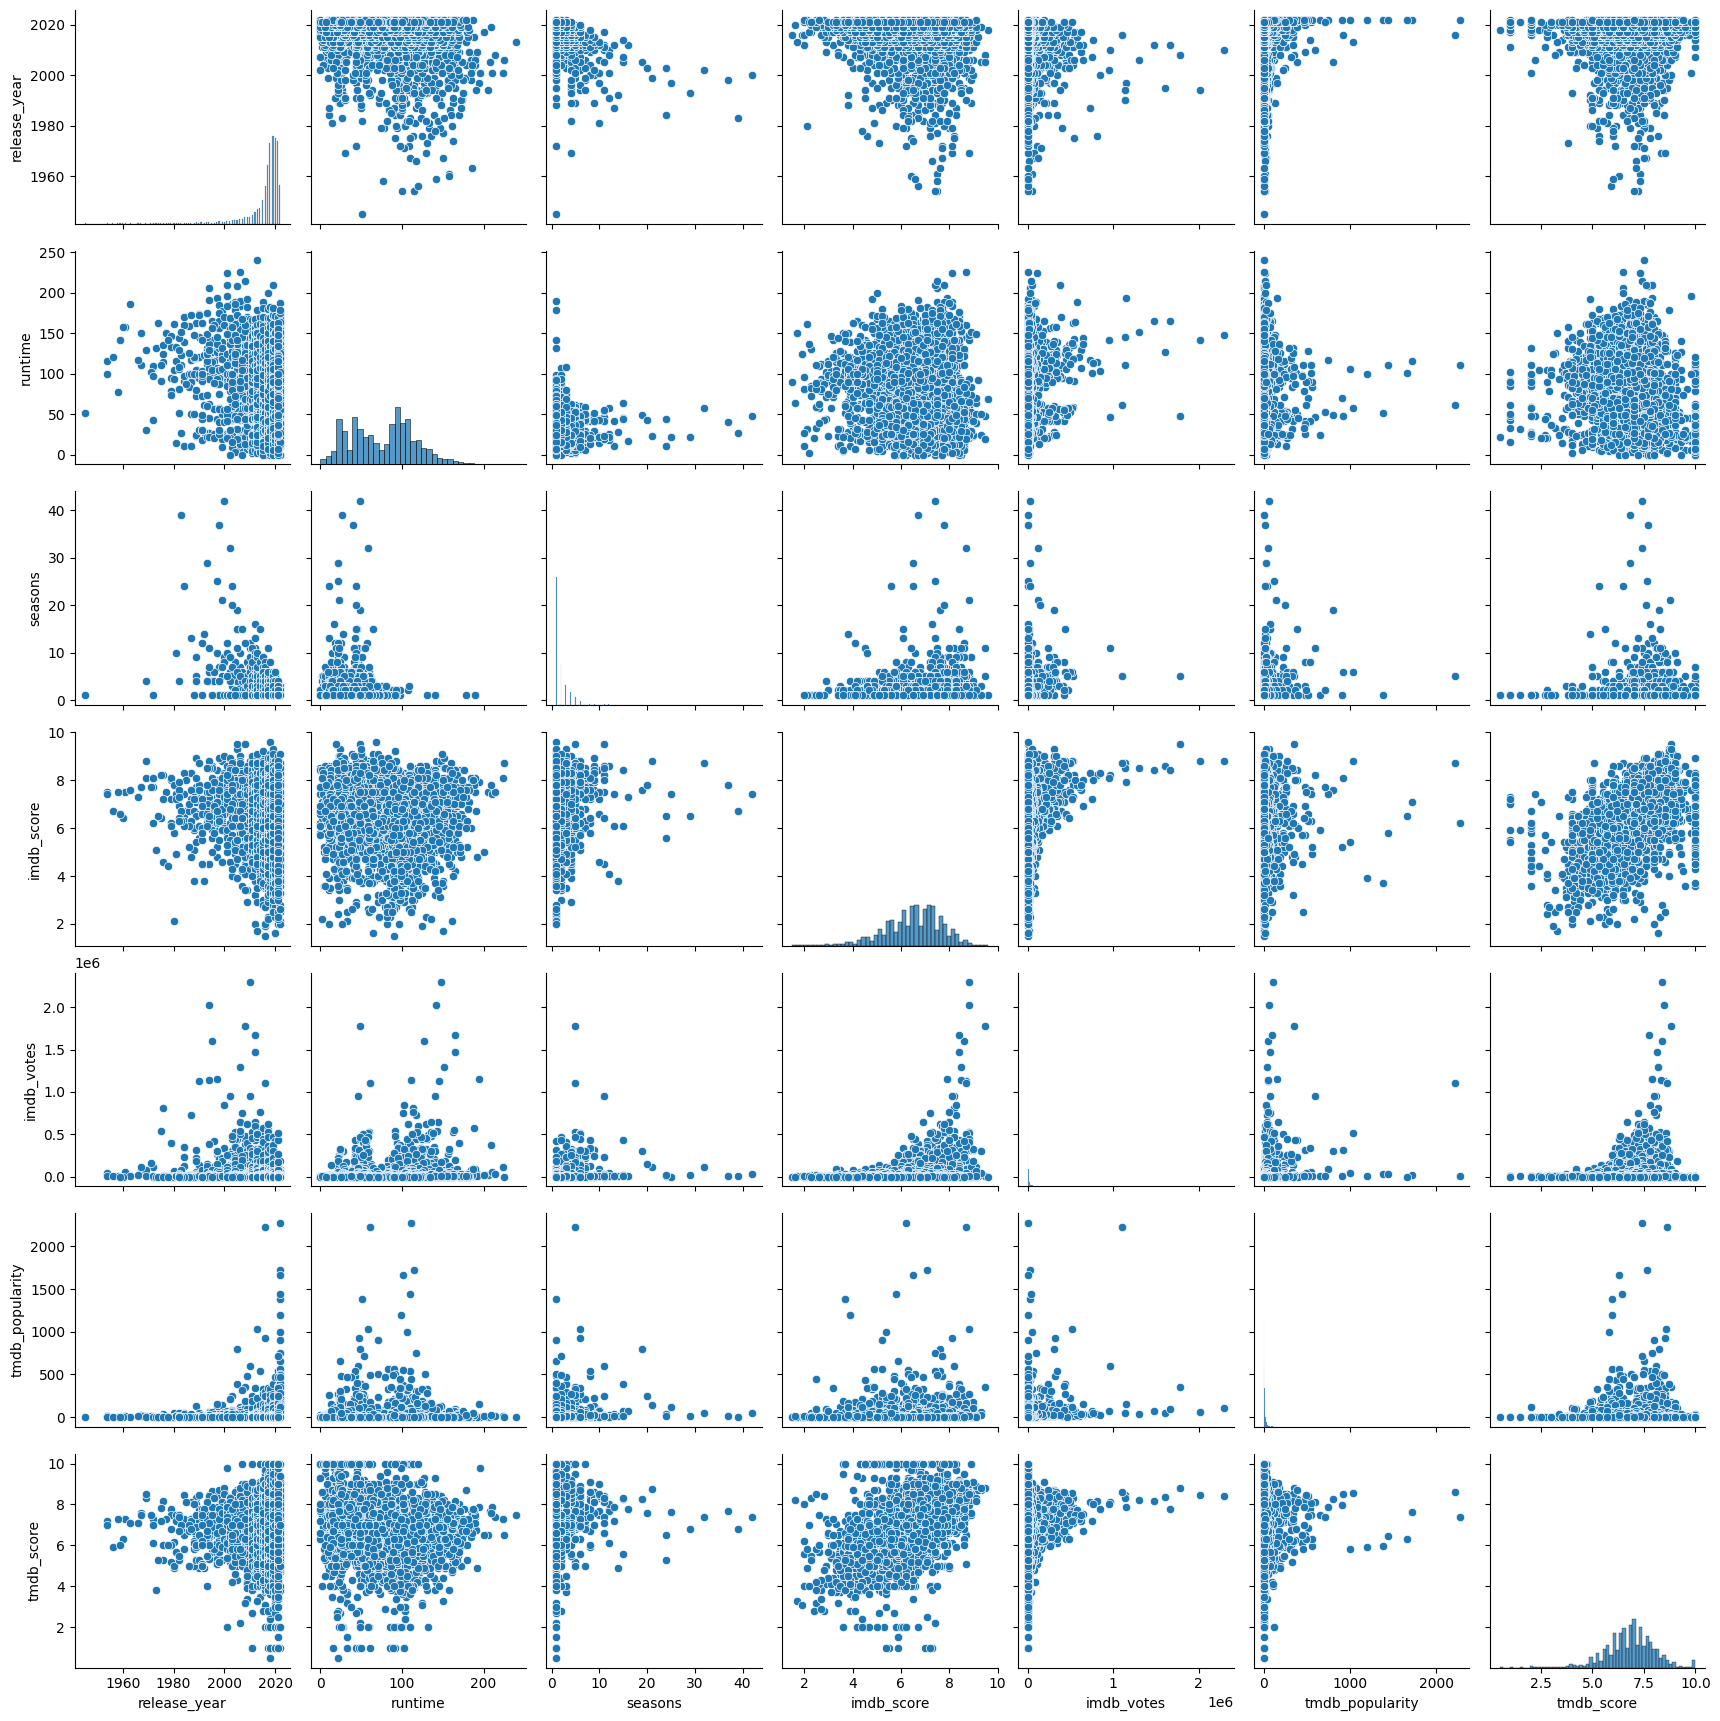

In [7]:
# plt.title('Pair plot before data preprocessing')
sns.pairplot(titles)
plt.show()

# no obvious linear relationship between each field is detected except for imdb_score and tmdb_score. However they represent the same metric for a movie or a TV show.
# imdb_score and tmdb_score are left-skewed distribution
# need to scale tmdb_popularity and imdb_votes

1.1.1 title
- remove one missing title

In [8]:
df_missing = titles[titles['title'].isna()]
print(df_missing)

# not only missing title, also also many na values in other columns
# drop one missing value in title
df_cleaned = titles.dropna(subset=['title'])

df_cleaned.shape


             id title   type description  release_year age_certification  \
1704  tm1063792   NaN  MOVIE         NaN          2015               NaN   

      runtime genres production_countries  seasons    imdb_id  imdb_score  \
1704       11     []                   []      NaN  tt4661188         NaN   

      imdb_votes  tmdb_popularity  tmdb_score  
1704         NaN              NaN         NaN  


(5849, 15)

1.1.2 imdb_votes and tmdb_popularity
- they measure how pupolar the movie or tvshow is.
- scaling, popularity is righted skewed, votes are centrally distributed
- imputation: votes is filled with mean, popularity is filled with median
    - pros
    - cons: there may be limitations, need to expand more

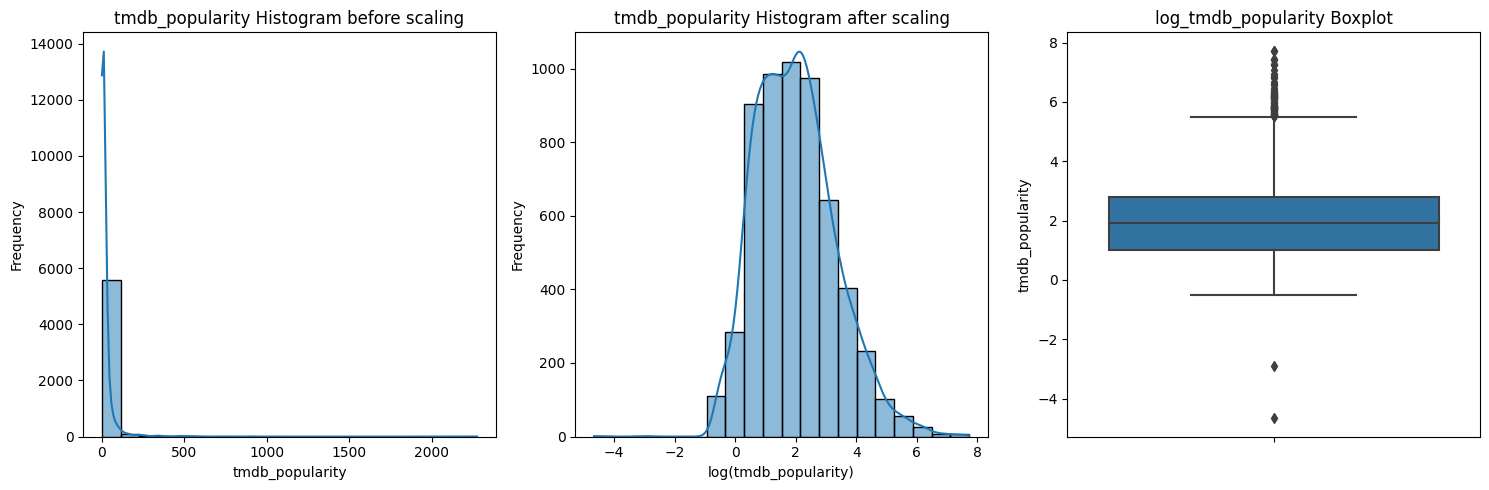

In [9]:
# tmdb popularity before scaling
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(df_cleaned['tmdb_popularity'], bins=20, kde=True)
plt.title('tmdb_popularity Histogram before scaling')
plt.xlabel('tmdb_popularity')
plt.ylabel('Frequency')


df_cleaned['tmdb_popularity_log'] = np.log(df_cleaned['tmdb_popularity'])

plt.subplot(1,3,2)
sns.histplot(df_cleaned['tmdb_popularity_log'], bins=20, kde=True)
plt.title('tmdb_popularity Histogram after scaling')
plt.xlabel('log(tmdb_popularity)')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(y=df_cleaned['tmdb_popularity_log'])
plt.title('log_tmdb_popularity Boxplot')
plt.ylabel('tmdb_popularity')

plt.tight_layout()
plt.show()

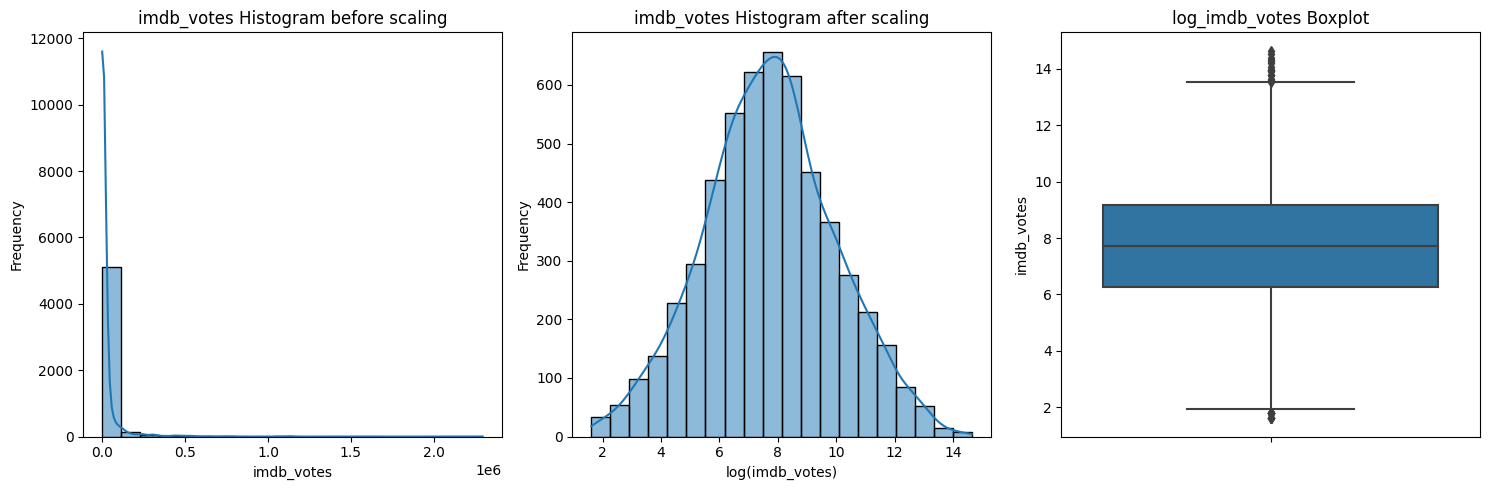

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(df_cleaned['imdb_votes'], bins=20, kde=True)
plt.title('imdb_votes Histogram before scaling')
plt.xlabel('imdb_votes')
plt.ylabel('Frequency')

df_cleaned['imdb_votes_log'] = np.log(df_cleaned['imdb_votes'])

plt.subplot(1,3,2)
sns.histplot(df_cleaned['imdb_votes_log'], bins=20, kde=True)
plt.title('imdb_votes Histogram after scaling')
plt.xlabel('log(imdb_votes)')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(y=df_cleaned['imdb_votes_log'])
plt.title('log_imdb_votes Boxplot')
plt.ylabel('imdb_votes')

plt.tight_layout()
plt.show()

1.1.3 imdb_score and tmdb score
- both are rated by audience
- both left skewed, filled missing value with median
- imputation: both are filled with median

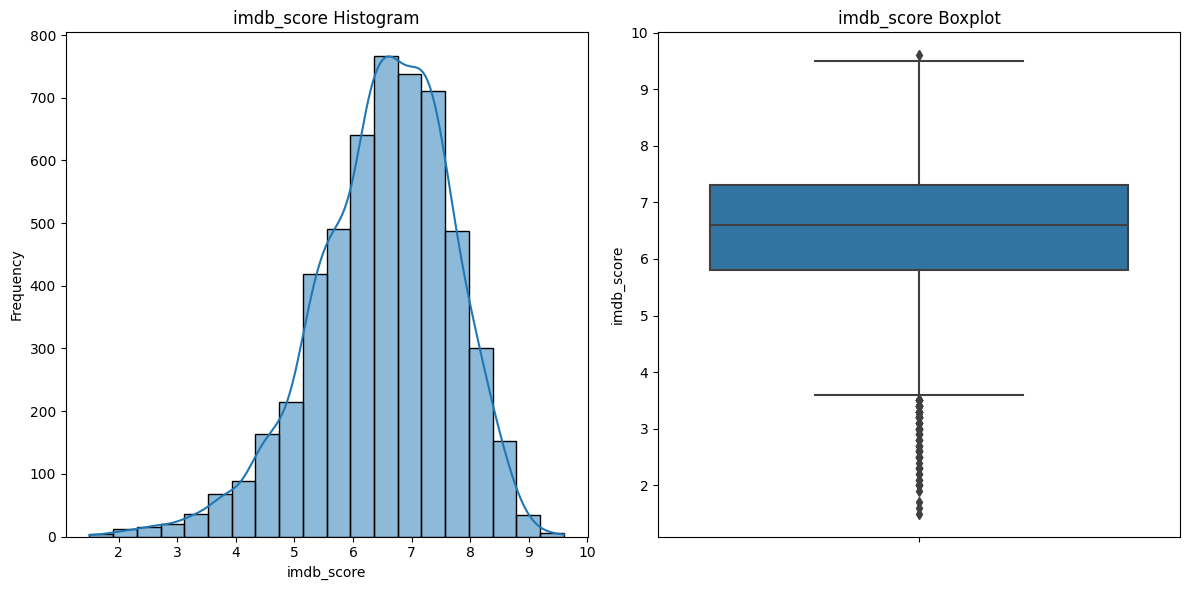

In [11]:
# imdb score
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['imdb_score'], bins=20, kde=True)
plt.title('imdb_score Histogram')
plt.xlabel('imdb_score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['imdb_score'])
plt.title('imdb_score Boxplot')
plt.ylabel('imdb_score')


plt.tight_layout()
plt.show()

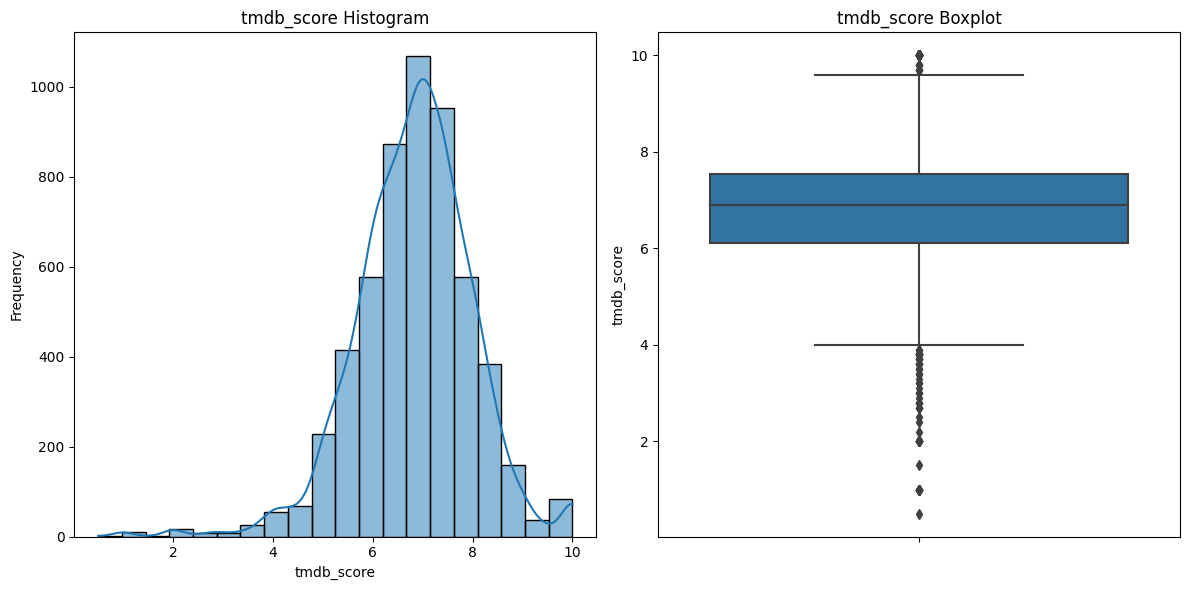

In [12]:
# tmdb score
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['tmdb_score'], bins=20, kde=True)
plt.title('tmdb_score Histogram')
plt.xlabel('tmdb_score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['tmdb_score'])
plt.title('tmdb_score Boxplot')
plt.ylabel('tmdb_score')

plt.tight_layout()
plt.show()

data imputation: filling in missing value?? don't fill in label

In [13]:
# data imputation

# imdb_score_median = df_cleaned['imdb_score'].median() 
# imdb_votes_mean = df_cleaned['imdb_votes'].mean()
# tmdb_popularity_median = df_cleaned['tmdb_popularity'].median()
# tmdb_score_median = df_cleaned['tmdb_score'].median()

# df_cleaned['imdb_score'].fillna(imdb_score_median,inplace=True)
# df_cleaned['imdb_votes'].fillna(imdb_votes_mean,inplace=True)
# df_cleaned['tmdb_popularity'].fillna(tmdb_popularity_median,inplace=True)
# df_cleaned['tmdb_score'].fillna(tmdb_score_median,inplace=True)


In [14]:
df_cleaned.corr(method='pearson')

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,tmdb_popularity_log,imdb_votes_log
release_year,1.000000,-0.173653,-0.504407,-0.129380,-0.208815,0.043244,0.032073,0.036771,-0.157326
runtime,-0.173653,1.000000,-0.139642,-0.148068,0.139760,0.002545,-0.277454,0.015298,0.241760
seasons,-0.504407,-0.139642,1.000000,0.106806,0.206079,0.168051,0.044023,0.280065,0.243397
imdb_score,-0.129380,-0.148068,0.106806,1.000000,0.190661,0.017675,0.570754,0.089097,0.233678
imdb_votes,-0.208815,0.139760,0.206079,0.190661,1.000000,0.209763,0.112960,0.307285,0.466184
tmdb_popularity,0.043244,0.002545,0.168051,0.017675,0.209763,1.000000,0.071894,0.520500,0.196959
tmdb_score,0.032073,-0.277454,0.044023,0.570754,0.112960,0.071894,1.000000,0.161451,0.091504
tmdb_popularity_log,0.036771,0.015298,0.280065,0.089097,0.307285,0.520500,0.161451,1.000000,0.618878
imdb_votes_log,-0.157326,0.241760,0.243397,0.233678,0.466184,0.196959,0.091504,0.618878,1.000000


In [15]:
# plt.title('Pair plot after data preprocessing')
# sns.pairplot(df_cleaned)
# plt.show()

1.1.2 drop age_certification 
- age certification tells us ... say TV-MA is imported most
- drop field age_certification 
    - due to many missing values (almost 45% of the whole data set)
    - Didn't find any opportunity to fill in the missing vlaue but still a lot useful info in other columns


In [16]:
df_cleaned['age_certification'].value_counts()

TV-MA    883
R        556
TV-14    474
PG-13    451
PG       233
TV-PG    188
G        124
TV-Y7    120
TV-Y     107
TV-G      79
NC-17     16
Name: age_certification, dtype: int64

In [17]:
# many missing value in age_certification, 
df_missing = df_cleaned[df_cleaned['age_certification'].isna()]
df_missing


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,tmdb_popularity_log,imdb_votes_log
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.6,3.015437,11.193574
10,tm44204,The Guns of Navarone,MOVIE,A team of allied saboteurs are assigned an imp...,1961,NaN,158,"['action', 'drama', 'war']","['GB', 'US']",NaN,tt0054953,7.5,50748.0,13.844,7.3,2.627852,10.834627
13,tm16479,White Christmas,MOVIE,Two talented song-and-dance men team up after ...,1954,NaN,115,"['romance', 'comedy']",['US'],NaN,tt0047673,7.5,42488.0,8.915,7.2,2.187735,10.656977
14,tm135083,Cairo Station,MOVIE,"Qinawi, a physically challenged peddler who ma...",1958,NaN,77,"['drama', 'crime', 'comedy']",['EG'],NaN,tt0051390,7.5,4471.0,5.546,7.3,1.713077,8.405367
17,tm14350,Alexandria… Why?,MOVIE,Set against the panoramic backdrop of war-torn...,1979,NaN,133,['drama'],['EG'],NaN,tt0077751,7.2,1727.0,1.370,6.0,0.314811,7.454141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5844,tm1074617,Bling Empire - The Afterparty,MOVIE,"The stars of ""Bling Empire"" discuss the show's...",2021,NaN,35,[],['US'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN,0.382538,3.806662
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,['drama'],[],NaN,tt11803618,7.7,348.0,NaN,NaN,NaN,5.852202
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,['comedy'],['CO'],NaN,tt14585902,3.8,68.0,26.005,6.3,3.258289,4.219508


1.1.8 Season

In [18]:
# seasons
df_cleaned['seasons'].value_counts()

1.0     1221
2.0      389
3.0      187
4.0      120
5.0       79
6.0       36
7.0       18
8.0       11
9.0        9
11.0       8
10.0       6
12.0       4
15.0       3
24.0       2
13.0       2
20.0       1
19.0       1
32.0       1
29.0       1
14.0       1
37.0       1
21.0       1
25.0       1
42.0       1
39.0       1
16.0       1
Name: seasons, dtype: int64

1.1.10 type: tv shows vs movies

In [19]:
# tv shows vs movies
type_counts = df_cleaned['type'].value_counts()
type_counts

MOVIE    3743
SHOW     2106
Name: type, dtype: int64

1.1.11 release year

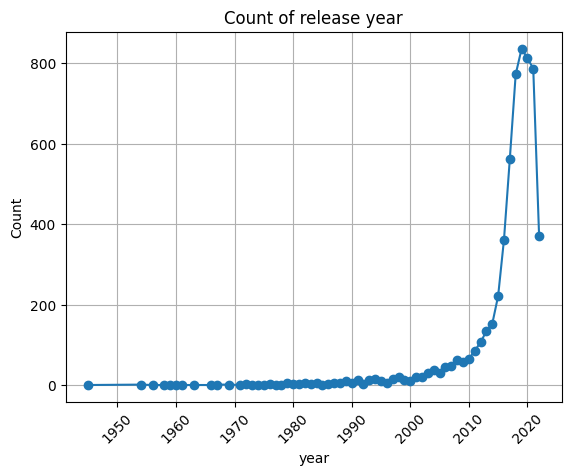

In [20]:
year_counts = df_cleaned['release_year'].value_counts().sort_index()
plt.plot(year_counts.index,year_counts.values,marker='o', linestyle='-')
plt.title('Count of release year')
plt.xlabel('year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1.1.12 run time
- 发现有时间为0的runtime，是否合理，考虑filter it out? or leave it， because some short one maybe less than a minute.

In [21]:
df_cleaned=df_cleaned[df_cleaned['runtime']>0]

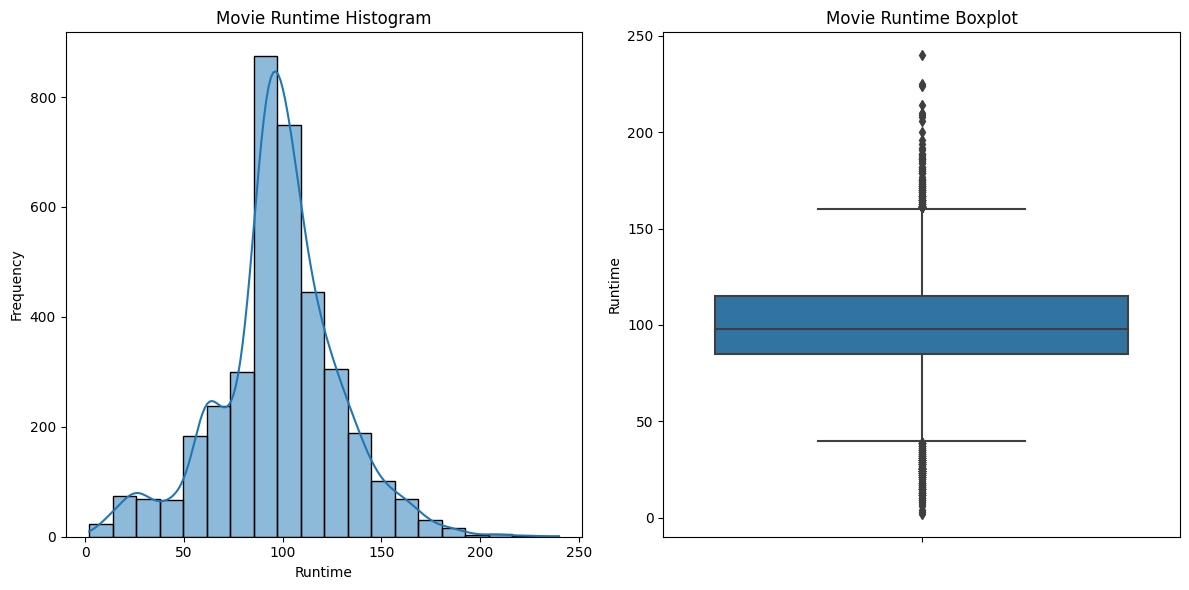

In [22]:
# movie run time
df_cleaned_movie = df_cleaned[df_cleaned['type']=='MOVIE']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned_movie['runtime'],bins=20,kde=True)
plt.title('Movie Runtime Histogram')
plt.xlabel('Runtime')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned_movie['runtime'])
plt.title('Movie Runtime Boxplot')
plt.ylabel('Runtime')

plt.tight_layout()
plt.show()



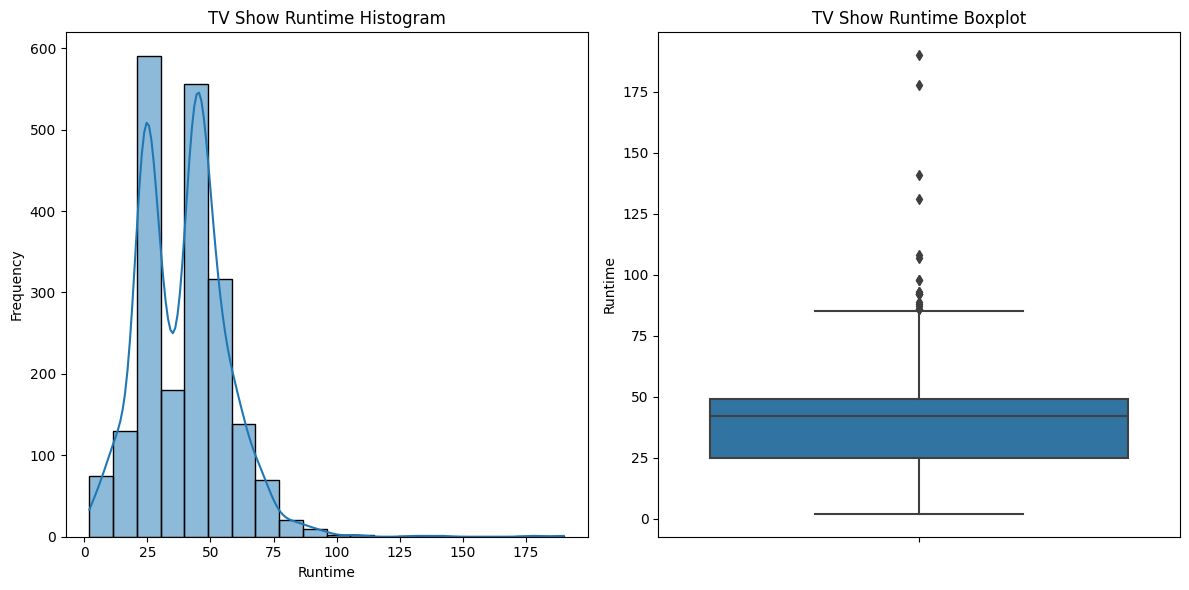

In [23]:
# tv show run time
df_cleaned_tvshow = df_cleaned[df_cleaned['type']=='SHOW']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned_tvshow['runtime'],bins=20,kde=True)
plt.title('TV Show Runtime Histogram')
plt.xlabel('Runtime')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned_tvshow['runtime'])
plt.title('TV Show Runtime Boxplot')
plt.ylabel('Runtime')

plt.tight_layout()
plt.show()

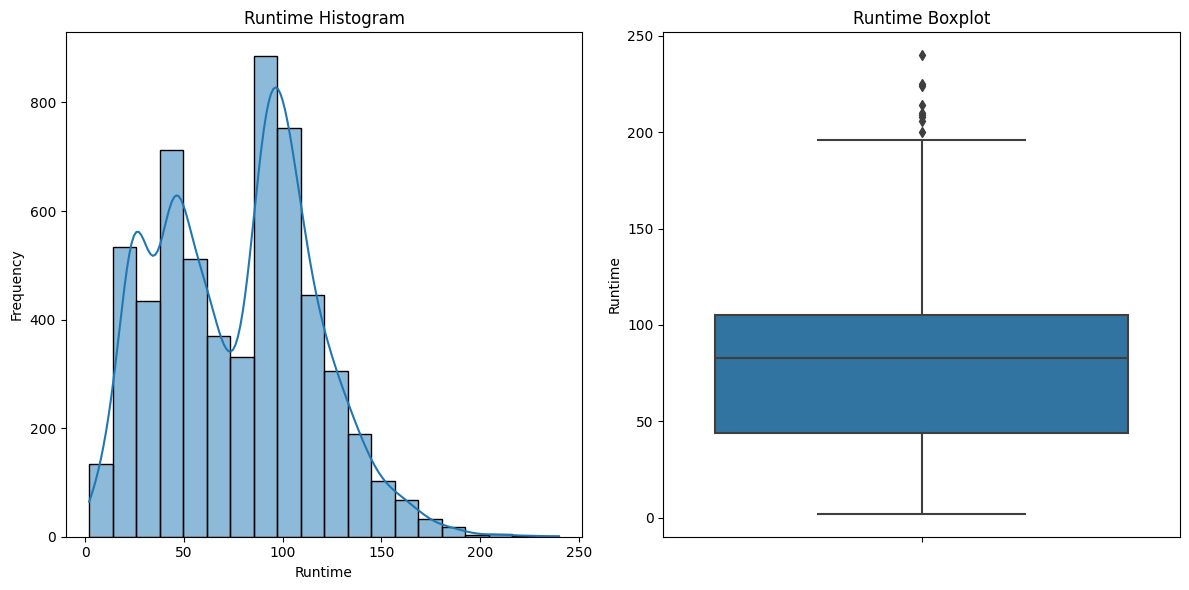

In [24]:
# runtime
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

sns.histplot(df_cleaned['runtime'],bins=20,kde=True)
plt.title('Runtime Histogram')
plt.xlabel('Runtime')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(y=df_cleaned['runtime'])
plt.title('Runtime Boxplot')
plt.ylabel('Runtime')

plt.tight_layout()
plt.show()

1.1.13 Text Preprocessing: title and description
- this is not a good way to do text processing as there are other languages, not just English

In [25]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # case folding
    text = str(text).lower()
    # remove all non-alphabetic characters
    letters_only = re.sub("[^a-zA-Z]"," ", text)
    tokens = word_tokenize(letters_only)
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ''.join(tokens)

    return text

df_cleaned_text = df_cleaned.dropna(subset=['description'])
df_cleaned_text['title'] = df_cleaned_text['title'].apply(preprocess_text)
df_cleaned_text['description'] = df_cleaned_text['description'].apply(preprocess_text)
 

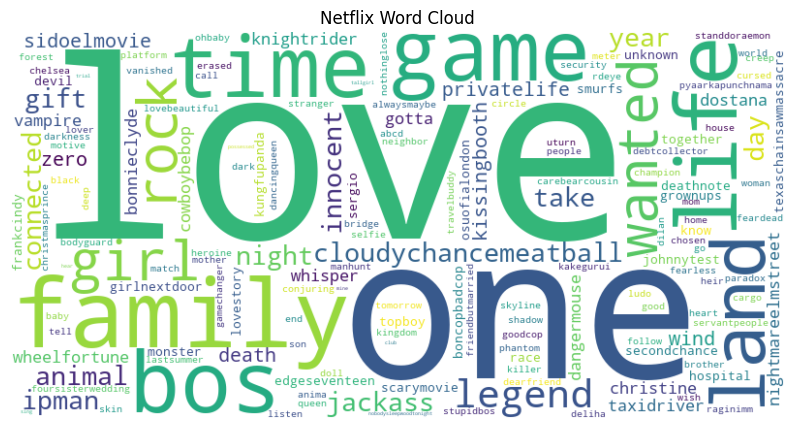

In [26]:
# word cloud
# 还是别加到report里了

combined_text = df_cleaned_text['title'] + ' ' + df_cleaned_text['description']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(combined_text))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Netflix Word Cloud')
plt.show()

#histogram top 20 for title and description each 

1.1.9 Add actor and director

In [27]:
# # credits
# credits['role'].value_counts()

# # combine dfs
# merged_df = pd.merge(df_cleaned, credits, left_on='id', right_on='id', how='inner')

# actors_grouped = merged_df.groupby('id')['person_id'].agg(list).reset_index()
# director_grouped = merged_df[merged_df['role']=='DIRECTOR'].groupby('id')['person_id'].agg(list).reset_index()

# actors_grouped.rename(columns={'person_id':'actor_ids'}, inplace=True)
# director_grouped.rename(columns={'person_id':'director_ids'}, inplace=True)

# tv_shows_df = pd.merge(df_cleaned,actors_grouped,on='id', how='left')
# tv_shows_df = pd.merge(tv_shows_df, director_grouped, on='id', how='left')

# tv_shows_df

1.1.4 Production Countries
-  transformed into list
-  no more actions were taken yet. 
-  It's assumed that most of the Netflex viewers are from English speaking countries. 

In [28]:
# deal with production countries
# 为什么没做one hot coding for production countries?
# 因为production countries大部分是美国，sparsity严重

df_cleaned['production_countries'] = df_cleaned['production_countries'].apply(lambda x:ast.literal_eval(x) if pd.notna(x) else [])
df_cleaned.head(5)


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,tmdb_popularity_log,imdb_votes_log
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],[US],1.0,NaN,NaN,NaN,0.600,NaN,-0.510826,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",[US],NaN,tt0075314,8.2,808582.0,40.965,8.179,3.712718,13.603037
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",[US],NaN,tt0068473,7.7,107673.0,10.010,7.300,2.303585,11.586854
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",[GB],NaN,tt0071853,8.2,534486.0,15.461,7.811,2.738321,13.189061
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","[GB, US]",NaN,tt0061578,7.7,72662.0,20.398,7.600,3.015437,11.193574


In [29]:
df_exploded = df_cleaned.explode('production_countries')

df_country_count = pd.DataFrame(df_exploded['production_countries'].value_counts())
df_country_count.reset_index(inplace=True)
df_country_count.columns = ['production country', 'count']

dict_country_counts = df_exploded['production_countries'].value_counts().to_dict()

df_country_count

,production country,count
0,US,2320
1,IN,622
2,GB,404
3,JP,287
4,FR,248
...,...,...
104,VE,1
105,Lebanon,1
106,DZ,1
107,BS,1


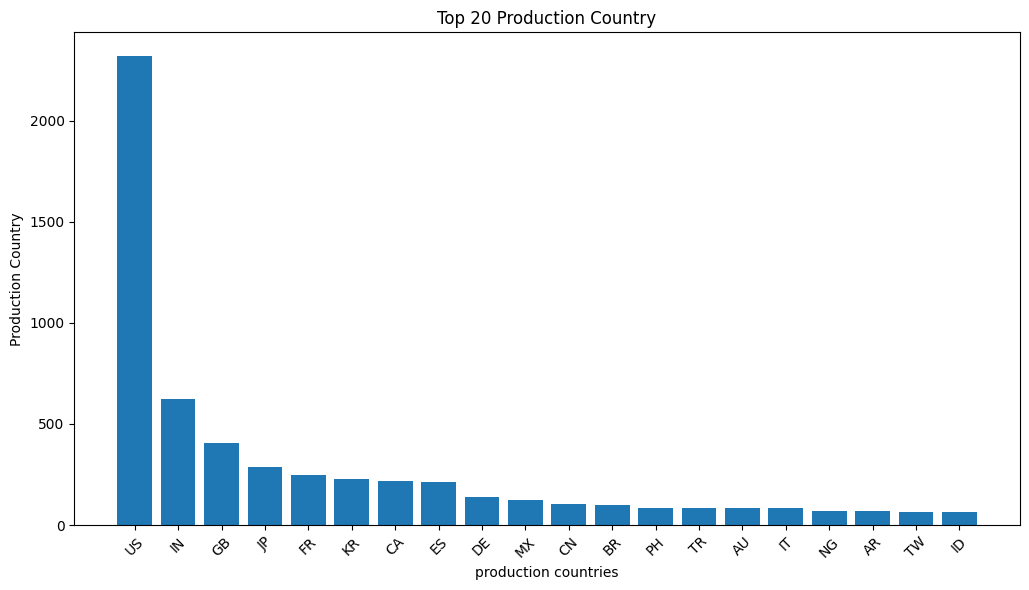

In [30]:
country_top = df_country_count.head(20)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.bar(country_top['production country'],country_top['count'])
plt.xlabel('production countries')
plt.xticks(rotation=45)
plt.ylabel('Production Country')
# plt.grid(True,linestyle='--', color='gray')
plt.title('Top 20 Production Country')

# # considering a pie chart
# plt.subplot(1,2,2)
# plt.pie(country_top['Production Country'], labels=country_top['Count'], autopct='%1.1f%%', startangle=140)  
# plt.title('Genres Count Distribution')
# plt.show()

plt.tight_layout()
plt.show()

In [31]:
country = df_country_count["production country"].to_list()
country = country[:10]

for idx, row in df_cleaned.iterrows():
    # print(idx)
    pro = row["production_countries"]
    if len(pro) == 0:
        df_cleaned.loc[idx,"production_countries_rep"] = ''
    else:
        for item in country:
            if item in pro:
                df_cleaned.loc[idx,"production_countries_rep"] = item
                break
            elif type(df_cleaned.loc[idx,"production_countries"]) == list:
                df_cleaned.loc[idx,"production_countries_rep"] = 'others'



In [32]:
# one hot encoding for production countries
# country_dummies = pd.get_dummies(df_cleaned['production_coutries_rep'].explode(), prefix='country')
df_cleaned = pd.get_dummies(df_cleaned, columns=['production_countries_rep'], prefix=['country'])
# country_dummies = genres_dummies.groupby(level=0).sum()

# df_encoded = pd.concat([df_cleaned,country_dummies],axis=1)

# df_exploded = df_encoded.explode('')

# _counts = df_exploded['genres'].value_counts()
# print(genres_counts)


1.1.7 Genres
- transformed from list

In [33]:
# transformed into list of words
df_cleaned['genres'] = df_cleaned['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df_cleaned


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,country_DE,country_ES,country_FR,country_GB,country_IN,country_JP,country_KR,country_MX,country_US,country_others
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,[documentation],[US],1.0,...,0,0,0,0,0,0,0,0,1,0
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"[drama, crime]",[US],NaN,...,0,0,0,0,0,0,0,0,1,0
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"[drama, action, thriller, european]",[US],NaN,...,0,0,0,0,0,0,0,0,1,0
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"[fantasy, action, comedy]",[GB],NaN,...,0,0,0,1,0,0,0,0,0,0
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"[war, action]","[GB, US]",NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"[romance, drama]",[NG],NaN,...,0,0,0,0,0,0,0,0,0,1
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,[drama],[],NaN,...,0,0,0,0,0,0,0,0,0,0
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,[comedy],[CO],NaN,...,0,0,0,0,0,0,0,0,0,1
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],[US],NaN,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# genres count
df_cleaned['genres_count'] = df_cleaned['genres'].apply(len)
df_cleaned['genres_count'].value_counts()


2     1720
1     1426
3     1288
4      732
5      385
6      142
7       61
0       57
8       17
9        6
10       1
Name: genres_count, dtype: int64

In [35]:
# one hot encoding for genres
genres_dummies = pd.get_dummies(df_cleaned['genres'].explode(), prefix='genre')
genres_dummies = genres_dummies.groupby(level=0).sum()

df_encoded = pd.concat([df_cleaned,genres_dummies],axis=1)

df_exploded = df_encoded.explode('genres')

genres_counts = df_exploded['genres'].value_counts()
print(genres_counts)


drama            2962
comedy           2321
thriller         1226
action           1155
romance           969
documentation     951
crime             934
animation         703
family            679
fantasy           630
scifi             589
european          443
horror            378
music             262
history           254
reality           232
sport             170
war               163
western            41
Name: genres, dtype: int64


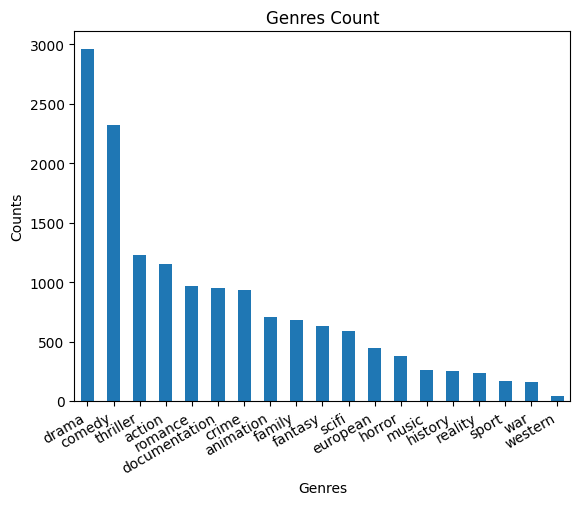

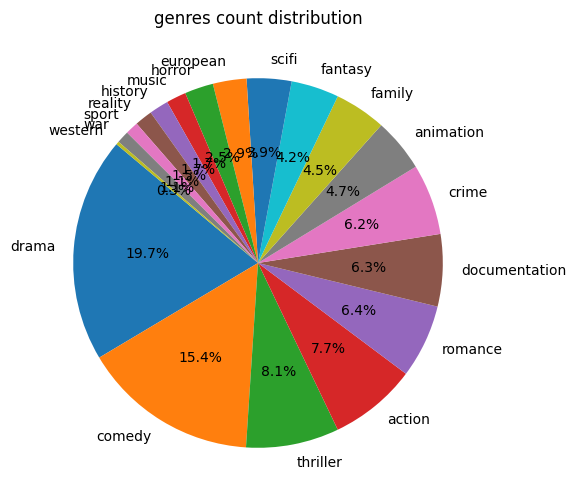

In [36]:
# genre
plt.figure()
genres_counts.plot(kind='bar')
plt.title('Genres Count')
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

plt.figure(figsize=(6,6))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('genres count distribution')
plt.show()

# Modelling

Drop irrelavnet featrues

In [37]:
# drop columns
columns_to_drop = ['age_certification','imdb_id','seasons','genres']
df_cleaned = df_encoded.drop(columns = columns_to_drop)

Label Encoding

In [38]:
# label enconding for categorical data
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()

df_cleaned['type'] = LabelEncoder.fit_transform(df_cleaned['type'])
# df_cleaned['production_countries_rep'] = LabelEncoder.fit_transform(df_cleaned['production_countries_rep'].astype(str))


StandardScaler

In [39]:
# Standard scalar for numberical
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['release_year','runtime','imdb_votes','tmdb_popularity']
df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

Correlation Heatmap

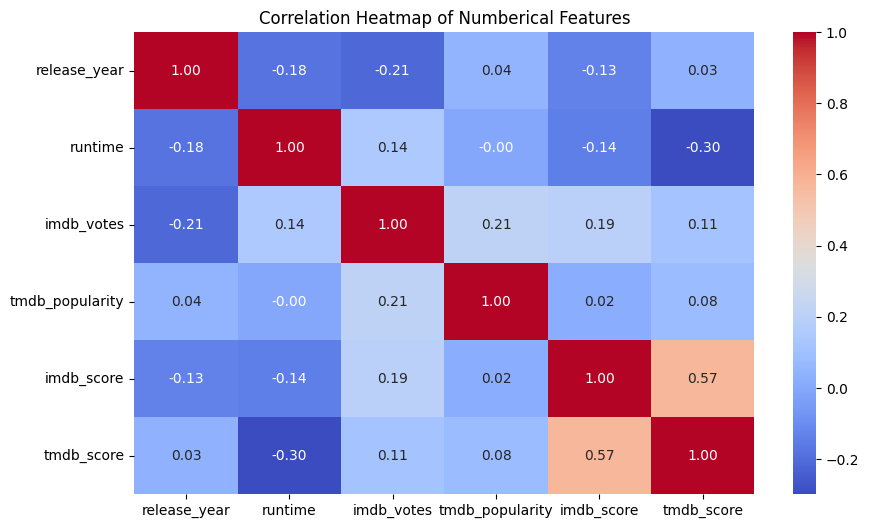

In [55]:
columns_for_corr = ['release_year','runtime','imdb_votes','tmdb_popularity','imdb_score','tmdb_score']
correlation_matrix = df_cleaned[columns_for_corr].corr()


plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numberical Features')
plt.show()

# Regression

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import calinski_harabasz_score

In [42]:
# df_cleaned['popularity'] = (df_cleaned['tmdb_popularity'] + df_cleaned['imdb_votes'])/2
df_cleaned = df_cleaned.dropna(subset=['tmdb_score','imdb_score'])
# df_cleaned = df_cleaned[df_cleaned['imdb_score']>0 and df_cleaned['tmdb_score']>0]
df_cleaned['score'] = (df_cleaned['tmdb_score'] + df_cleaned['imdb_score'])/2

df_cleaned.columns
# df_cleaned.shape[0]

Index(['id', 'title', 'type', 'description', 'release_year', 'runtime',
       'production_countries', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score', 'tmdb_popularity_log', 'imdb_votes_log', 'country_',
       'country_CA', 'country_DE', 'country_ES', 'country_FR', 'country_GB',
       'country_IN', 'country_JP', 'country_KR', 'country_MX', 'country_US',
       'country_others', 'genres_count', 'genre_action', 'genre_animation',
       'genre_comedy', 'genre_crime', 'genre_documentation', 'genre_drama',
       'genre_european', 'genre_family', 'genre_fantasy', 'genre_history',
       'genre_horror', 'genre_music', 'genre_reality', 'genre_romance',
       'genre_scifi', 'genre_sport', 'genre_thriller', 'genre_war',
       'genre_western', 'score'],
      dtype='object')

In [43]:
df_cleaned.describe()

,type,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,tmdb_popularity_log,imdb_votes_log,country_,...,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western,score
count,5137.000000,5137.000000,5137.000000,5137.000000,5123.000000,5137.000000,5137.000000,5137.000000,5123.000000,5137.000000,...,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000
mean,0.360522,-0.017549,0.045935,6.515885,0.009334,0.017220,6.822387,2.109731,7.875032,0.021608,...,0.069690,0.045552,0.040491,0.180650,0.106288,0.032704,0.224255,0.029784,0.007592,6.669136
std,0.480199,1.013216,0.992062,1.152708,1.017899,1.042368,1.144799,1.279123,2.136245,0.145414,...,0.254649,0.208531,0.197126,0.384766,0.308236,0.177878,0.417132,0.170007,0.086809,1.018632
min,0.000000,-8.993493,-1.932325,1.600000,-0.244849,-0.270084,1.000000,-0.510826,1.609438,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,0.000000,-0.059736,-0.799973,5.800000,-0.238504,-0.238886,6.100000,1.147720,6.419180,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.050000
50%,0.000000,0.228450,0.229439,6.600000,-0.219021,-0.185686,6.900000,2.015036,7.816820,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.750000
75%,1.000000,0.516635,0.718409,7.300000,-0.137232,-0.062078,7.500000,2.868353,9.242419,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000
max,1.000000,0.804821,3.806643,9.500000,23.677172,27.533913,10.000000,7.729315,14.645908,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.450000


In [44]:
# columns_selected = ['type', 'release_year', 'runtime',
#        'imdb_score', 'imdb_votes', 'tmdb_popularity',
#        'tmdb_score', 'rep_production_countries',
#        'genre_action', 'genre_animation', 'genre_comedy',
#        'genre_crime', 'genre_documentation', 'genre_drama', 'genre_european',
#        'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror',
#        'genre_music', 'genre_reality', 'genre_romance', 'genre_scifi',
#        'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']


columns_selected = ['type', 'release_year', 'runtime','score', 
       'country_CA', 'country_DE', 'country_ES', 'country_FR', 'country_GB',
       'country_IN', 'country_JP', 'country_KR', 'country_MX', 'country_US',
       'country_others',
       'genre_action', 'genre_animation', 'genre_comedy',
       'genre_crime', 'genre_documentation', 'genre_drama', 'genre_european',
       'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror',
       'genre_music', 'genre_reality', 'genre_romance', 'genre_scifi',
       'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']
df_selected = df_cleaned[columns_selected]
df_selected

,type,release_year,runtime,score,country_CA,country_DE,country_ES,country_FR,country_GB,country_IN,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
1,0,-5.823450,0.950027,8.1895,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-6.399821,0.821350,7.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,-5.967543,0.358115,8.0055,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-7.120286,1.876497,7.6500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,-6.832100,-1.211737,8.5530,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5838,0,0.660728,0.563997,5.7500,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5842,0,0.660728,-1.340414,5.9500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5843,0,0.660728,0.409586,5.1500,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5847,0,0.660728,0.332380,5.0500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X = df_selected.drop(columns=['score'])
y = df_selected['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [46]:
# Linear regression
linear_reg = LinearRegression()
linear_scores = cross_val_score(linear_reg, X, y, cv=5, scoring='neg_mean_squared_error')
linear_r2_scores = cross_val_score(linear_reg, X, y, cv=5, scoring='r2')
linear_rmse_scores = (-linear_scores)**0.5

print("Linear Regression Cross-Validation RMSE Scores:")
print(linear_rmse_scores)
print("Linear Regression Mean RMSE:", linear_rmse_scores.mean())
print("Linear Regression Cross-Validation R^2 Scores:")
print(linear_r2_scores)
print("Linear Regression Mean R^2:", linear_r2_scores.mean())

Linear Regression Cross-Validation RMSE Scores:
[0.92479826 0.81297599 0.88206138 0.91362872 0.86776127]
Linear Regression Mean RMSE: 0.8802451245739338
Linear Regression Cross-Validation R^2 Scores:
[0.18580672 0.328769   0.25097241 0.24262979 0.2141715 ]
Linear Regression Mean R^2: 0.2444698841139757


In [47]:
# # random forest
# rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_scores = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error')
# rf_r2_scores = cross_val_score(rf_reg, X, y, cv=5, scoring='r2')
# rf_rmse_scores = (-rf_scores)**0.5

# print("Random Forest Regression Cross-Validation RMSE Scores:")
# print(rf_rmse_scores)
# print("Random Forest Regression Mean RMSE:", rf_rmse_scores.mean())
# print("Random Forest Regression Cross-Validation R^2 Scores:")
# print(rf_r2_scores)
# print("Random Forest Regression Mean R^2:", rf_r2_scores.mean())

# Classification
predict 2 classes as per popularity and votes

In [48]:
columns_selected = ['type', 'release_year', 'runtime','tmdb_popularity', 
       'country_CA', 'country_DE', 'country_ES', 'country_FR', 'country_GB',
       'country_IN', 'country_JP', 'country_KR', 'country_MX', 'country_US',
       'country_others',
       'genre_action', 'genre_animation', 'genre_comedy',
       'genre_crime', 'genre_documentation', 'genre_drama', 'genre_european',
       'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror',
       'genre_music', 'genre_reality', 'genre_romance', 'genre_scifi',
       'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']
df_selected = df_cleaned[columns_selected]
df_selected

,type,release_year,runtime,tmdb_popularity,country_CA,country_DE,country_ES,country_FR,country_GB,country_IN,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
1,0,-5.823450,0.950027,0.223576,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-6.399821,0.821350,-0.155001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,-5.967543,0.358115,-0.088336,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-7.120286,1.876497,-0.027957,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,-6.832100,-1.211737,-0.061968,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5838,0,0.660728,0.563997,-0.136338,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5842,0,0.660728,-1.340414,0.380082,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5843,0,0.660728,0.409586,-0.246297,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5847,0,0.660728,0.332380,0.040616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# df_selected['popularity_cat'] = pd.qcut(df_selected['popularity'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
# df_selected['popularity_num'] = pd.qcut(df_selected['popularity'], q=5, labels=[1,2,3,4,5])
df_selected['tmdb_popularity'].dropna(inplace=True)
df_selected['popularity_cat'] = pd.qcut(df_selected['tmdb_popularity'], q=2, labels=['bad','good'])
df_selected.shape

(5137, 35)

In [50]:
# df_selected['imdb_votes_category'] = pd.qcut(df_selected['imdb_votes'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
# df_selected['imdb_votes_num'] = pd.qcut(df_selected['imdb_votes'], q=5, labels=[1,2,3,4,5])
X = df_selected.drop(columns=['tmdb_popularity','popularity_cat'])
y = df_selected['popularity_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [51]:
dt_classifier = DecisionTreeClassifier(random_state=17)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)

dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)
print("Decision Tree Classification Report:")
print(dt_classification_report)


Decision Tree Classification Report:
              precision    recall  f1-score   support

         bad       0.70      0.74      0.72       491
        good       0.75      0.71      0.73       537

    accuracy                           0.72      1028
   macro avg       0.72      0.72      0.72      1028
weighted avg       0.73      0.72      0.72      1028



In [52]:
baseline_classifier = DummyClassifier(strategy="most_frequent")
baseline_classifier.fit(X_train, y_train)
baseline_predictions = baseline_classifier.predict(X_test)

baseline_confusion_matrix = confusion_matrix(y_test, baseline_predictions)
baseline_classification_report = classification_report(y_test, baseline_predictions)

print("\n0R Baseline Classification Report:")
print(baseline_classification_report)


0R Baseline Classification Report:
              precision    recall  f1-score   support

         bad       0.48      1.00      0.65       491
        good       0.00      0.00      0.00       537

    accuracy                           0.48      1028
   macro avg       0.24      0.50      0.32      1028
weighted avg       0.23      0.48      0.31      1028



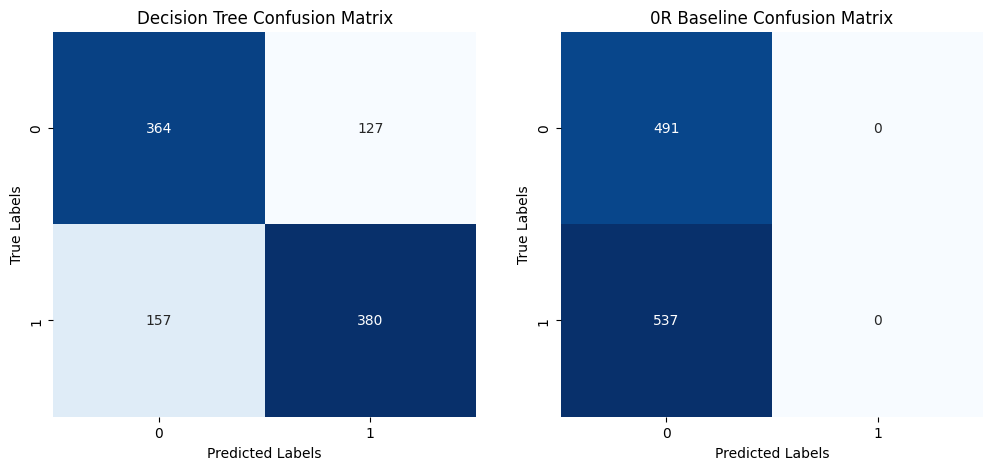

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(dt_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.subplot(1, 2, 2)
sns.heatmap(baseline_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("0R Baseline Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()